In [26]:
%pylab inline

import sim

from trajectory import min_snap_trajectory

Populating the interactive namespace from numpy and matplotlib


/home/swarm/.local/lib/python3.6/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['grid']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [27]:
sim.simxFinish(-1)  # Close opened connections
clientID = sim.simxStart('127.0.0.1', 19999, True, True, 5000, 5)  # Connect to CoppeliaSim

if clientID != -1:
    print('Connected')

    # Now try to retrieve data in a blocking fashion (i.e. a service call):
    res, objs = sim.simxGetObjects(clientID, sim.sim_handle_all, sim.simx_opmode_blocking)

    print('Simulation time in milliseconds: ', sim.simxGetLastCmdTime(clientID))
    
    # Get Object position
    name = 'Omnirob'
    err_code, cuboid = sim.simxGetObjectHandle(clientID, name, sim.simx_opmode_blocking)
    res, position = sim.simxGetObjectPosition(clientID, cuboid, -1, sim.simx_opmode_blocking)  
    res, position = sim.simxGetObjectOrientation(clientID, cuboid, -1, sim.simx_opmode_blocking)  
    print('Omnirob is at [x,y,z]=', position)
    
    # Now close the connection to CoppeliaSim:
    sim.simxGetPingTime(clientID)
    sim.simxFinish(clientID)
    print('Disconnected')
else:
    print('Failed connecting to remote API server')

Connected
Simulation time in milliseconds:  35200
Omnirob is at [x,y,z]= [-9.98960604192689e-06, -0.0002390141598880291, -1.5708622932434082]
Disconnected


In [28]:
def Rotz(Θ):
    R = array([[cos(Θ), -sin(Θ),0], [sin(Θ), cos(Θ),0],[0,0,1]])
    return R

In [29]:
class robot():
    
    def __init__(self, frame_name, motor_names=[], client_id=0):  
        # If there is an existing connection
        if client_id:
                self.client_id = client_id
        else:
            self.client_id = self.open_connection()
            
        self.motors = self._get_handlers(motor_names) 
        
        # Robot frame
        self.frame =  self._get_handler(frame_name)
            
        
    def open_connection(self):
        sim.simxFinish(-1)  # just in case, close all opened connections
        self.client_id = sim.simxStart('127.0.0.1', 19999, True, True, 5000, 5)  # Connect to CoppeliaSim 
        
        if clientID != -1:
            print('Robot connected')
        else:
            print('Connection failed')
        return clientID
        
    def close_connection(self):    
        sim.simxGetPingTime(self.client_id)  # Before closing the connection to CoppeliaSim, make sure that the last command sent out had time to arrive.
        sim.simxFinish(self.client_id)  # Now close the connection to CoppeliaSim:
        print('Connection closed')
    
    def isConnected(self):
        c,result = sim.simxGetPingTime(self.client_id)
        # Return true if the robot is connected
        return result > 0         
        
    def _get_handler(self, name):
        err_code, handler = sim.simxGetObjectHandle(self.client_id, name, sim.simx_opmode_blocking)
        return handler
    
    def _get_handlers(self, names):
        handlers = []
        for name in names:
            handler = self._get_handler(name)
            handlers.append(handler)
        
        return handlers

    def send_motor_velocities(self, vels):
        for motor, vel in zip(self.motors, vels):
            err_code = sim.simxSetJointTargetVelocity(self.client_id, 
                                                      motor, vel, sim.simx_opmode_streaming)      
            
    def set_position(self, position, relative_object=-1):
        if relative_object != -1:
            relative_object = self._get_handler(relative_object)        
        sim.simxSetObjectPosition(clientID, self.frame, relative_object, position, sim.simx_opmode_oneshot)
        
    def simtime(self):
        return sim.simxGetLastCmdTime(self.client_id)
    
    def get_position(self, relative_object=-1):
        # Get position relative to an object, -1 for global frame
        if relative_object != -1:
            relative_object = self._get_handler(relative_object)
        res, position = sim.simxGetObjectPosition(self.client_id, self.frame, relative_object, sim.simx_opmode_blocking)        
        return array(position)

    def get_orientation(self, relative_object=-1):
        # Get position relative to an object, -1 for global frame
        if relative_object != -1:
            relative_object = self._get_handler(relative_object)
        res, euler = sim.simxGetObjectOrientation(self.client_id, self.frame, relative_object, sim.simx_opmode_blocking)        
        return array(euler)    
     
    
    def get_object_position(self, object_name):
        # Get Object position in the world frame
        err_code, object_h = sim.simxGetObjectHandle(self.client_id, object_name, sim.simx_opmode_blocking)
        res, position = sim.simxGetObjectPosition(self.client_id, object_h, -1, sim.simx_opmode_blocking)
        
        return array(position)
    
    def get_object_relative_position(self, object_name):        
        # Get Object position in the robot frame
        err_code, object_h = sim.simxGetObjectHandle(self.client_id, object_name, sim.simx_opmode_blocking)
        res, position = sim.simxGetObjectPosition(self.client_id, object_h, self.frame, sim.simx_opmode_blocking)
        return array(position)

## 1. Define a Grid where the cells with obstacles are occupied
Example, a grid of 40x60 in a rectangular map of 2x3 m^2. The obstacles are random.

NOTE: for the workshop, you will not fill them randomly. It will be depending on the obstacles.

In [30]:
n, m = 20,20  # number of rows and columns respectively.

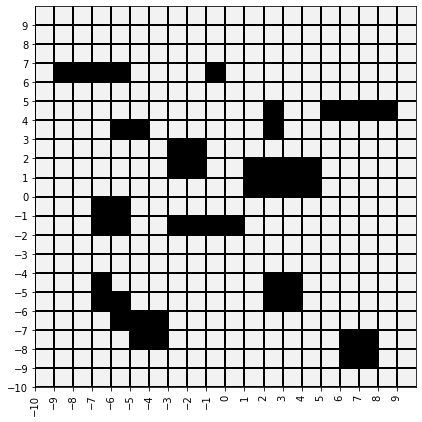

In [32]:
# Create a matrix to represent the cells of the grid
grid_cells = np.zeros((4,6))

# Random obstacles for this example. 
# np.random.seed(0)  # You can remove the random seed if you want to test different random grids.
# grid = np.random.rand(4, 6)
# threshold = 0.8
# grid[grid > threshold] = 1
# grid[grid<= threshold] = 0

n, m = 20,20
check = np.zeros((20, 20))
check[3:4,1:5] = check[5,15:19] = check[11:12,7:11] =  1
check[8:10,11:13] = 1
check[14:16,3] = check[15:17,4] = check[16:18,5:7] = 1

check[3,9] = check[5:7,12] = check[6,4:6] = check[7:9,7:9] = check[10:12,3:5] = 1
check[14:16,12:14] = check[17:19,16:18] = check[8:10,13:15] = 1

grid = check

def draw_grid():
    fig, ax = plt.subplots(figsize=(7, 7))
    cmap = matplotlib.colors.ListedColormap(['0.95', 'black']) # Colors (0.9 is the almost white in gray scale)
    ax.imshow(grid, extent=[-10, 10., -10., 10], cmap=cmap, origin='upper')
    ax.grid(which='major', axis='both', linestyle='-', color='k', linewidth=2)
    ax.set_xticks(np.arange(-10, 10, 1));
    ax.set_yticks(np.arange(-10, 10, 1));
    xticks(rotation=90)

draw_grid()


(<Figure size 1080x1080 with 1 Axes>, <AxesSubplot:>)

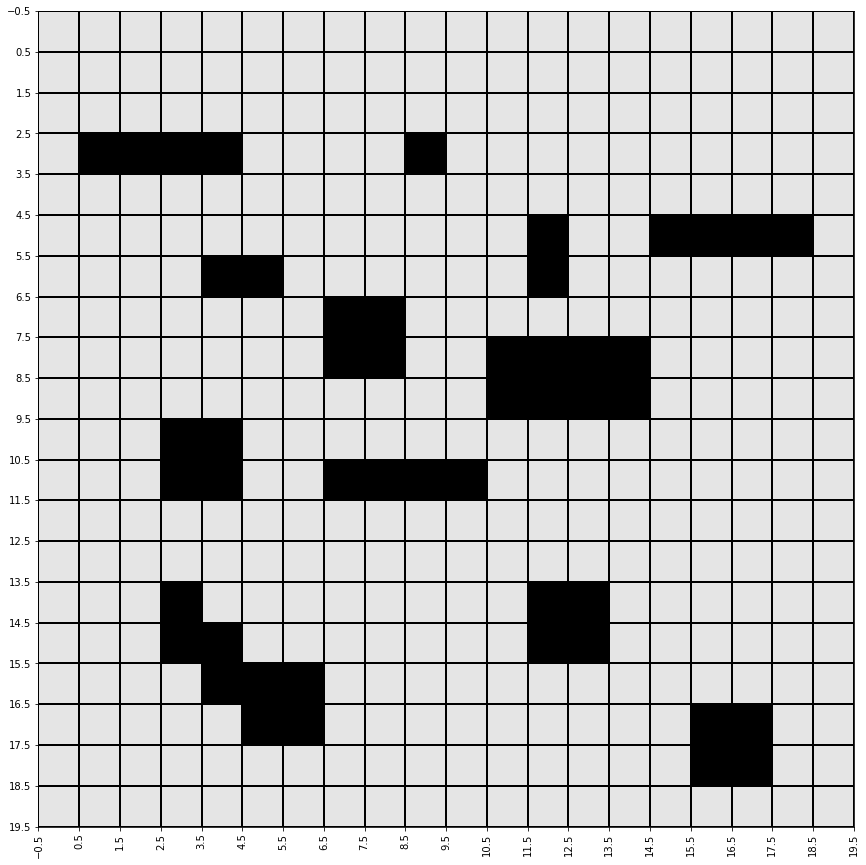

In [33]:
# Plot the grid
def draw_grid():
    fig, ax = plt.subplots(figsize=(15, 15))
    cmap = matplotlib.colors.ListedColormap(['0.9', 'black']) # Colors (0.9 is the almost white in gray scale)
    ax.imshow(grid, cmap=cmap, origin='upper')
    ax.grid(which='major', axis='both', linestyle='-', color='k', linewidth=2)
    ax.set_xticks(np.arange(-0.5, m, 1));
    ax.set_yticks(np.arange(-0.5, n, 1));
    xticks(rotation=90)
    
    return fig, ax

draw_grid()

## 2. Create a graph to represent the grid
Every cell is a node, and adjecent vertices are connected by edges.

In [34]:
import networkx as nx
# This function automatically creates the graph in a grid.
G = nx.grid_2d_graph(n, m) 
print("Number of nodes in a full grid (n*m): ",len(G.nodes()))
# Delete nodes with obstacles
for i in range(n):
    for j in range(m):
        # if the node is an obstacle
        if grid[i][j] == 1:  
            G.remove_node((i,j))

# print("Number of nodes after removing obstacles: ",len(G.nodes()))
# print("Nodes:", G.nodes())

Number of nodes in a full grid (n*m):  400
Number of nodes after removing obstacles:  351
Nodes: [(0, 0), (0, 1), (0, 2), (0, 3), (0, 4), (0, 5), (0, 6), (0, 7), (0, 8), (0, 9), (0, 10), (0, 11), (0, 12), (0, 13), (0, 14), (0, 15), (0, 16), (0, 17), (0, 18), (0, 19), (1, 0), (1, 1), (1, 2), (1, 3), (1, 4), (1, 5), (1, 6), (1, 7), (1, 8), (1, 9), (1, 10), (1, 11), (1, 12), (1, 13), (1, 14), (1, 15), (1, 16), (1, 17), (1, 18), (1, 19), (2, 0), (2, 1), (2, 2), (2, 3), (2, 4), (2, 5), (2, 6), (2, 7), (2, 8), (2, 9), (2, 10), (2, 11), (2, 12), (2, 13), (2, 14), (2, 15), (2, 16), (2, 17), (2, 18), (2, 19), (3, 0), (3, 5), (3, 6), (3, 7), (3, 8), (3, 10), (3, 11), (3, 12), (3, 13), (3, 14), (3, 15), (3, 16), (3, 17), (3, 18), (3, 19), (4, 0), (4, 1), (4, 2), (4, 3), (4, 4), (4, 5), (4, 6), (4, 7), (4, 8), (4, 9), (4, 10), (4, 11), (4, 12), (4, 13), (4, 14), (4, 15), (4, 16), (4, 17), (4, 18), (4, 19), (5, 0), (5, 1), (5, 2), (5, 3), (5, 4), (5, 5), (5, 6), (5, 7), (5, 8), (5, 9), (5, 10), (5,

## Plot the graph



In [2]:
fig, ax = plt.subplots(figsize=(15, 15))

# Position of the nodes
pos = {node:(node[1], -node[0]) for node in G.nodes()}  # by making (x,y) = (j, i), where i and j iterate over the columns and the rows respectively.

NameError: name 'plt' is not defined

### Overlapping the grid and graph

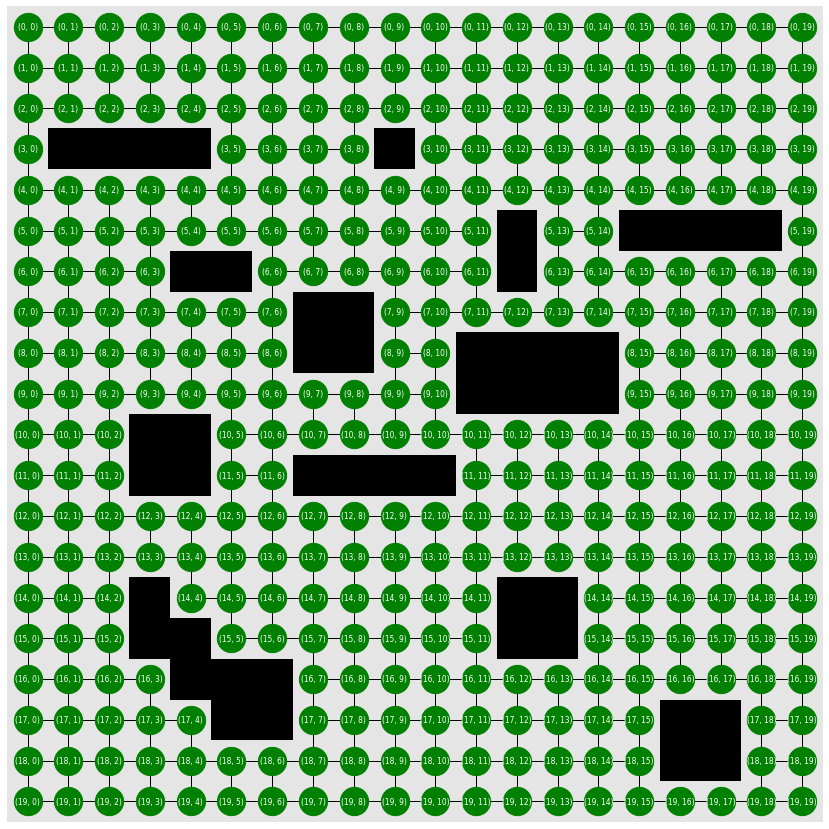

In [36]:
# Plot grid
# fig, ax = plt.subplots(figsize=(15, 15))
fig, ax = draw_grid()

# Plot the graph
pos = {node:(node[1], node[0]) for node in G.nodes()}   # by making (x,y) = j, -i, where i and j iterate over the columns and the rows respectively.
# nx.draw(G, pos, font_size=10, with_labels=True, node_size=700, node_color="g")
nx.draw(G, pos, font_size=7.5, with_labels=True, node_size=800, node_color="g", font_color="w")

fig.savefig('exp_e22a.pdf', bbox_inches="tight")


# BFS Algorithm 

In [41]:
# start_node =  (1, 17)
# end_node = (18,2)

start_node =  (19, 17)
end_node = (18,2)


# Run BFS to generate a tree
bfs_tree = nx.bfs_tree(G, source=start_node)


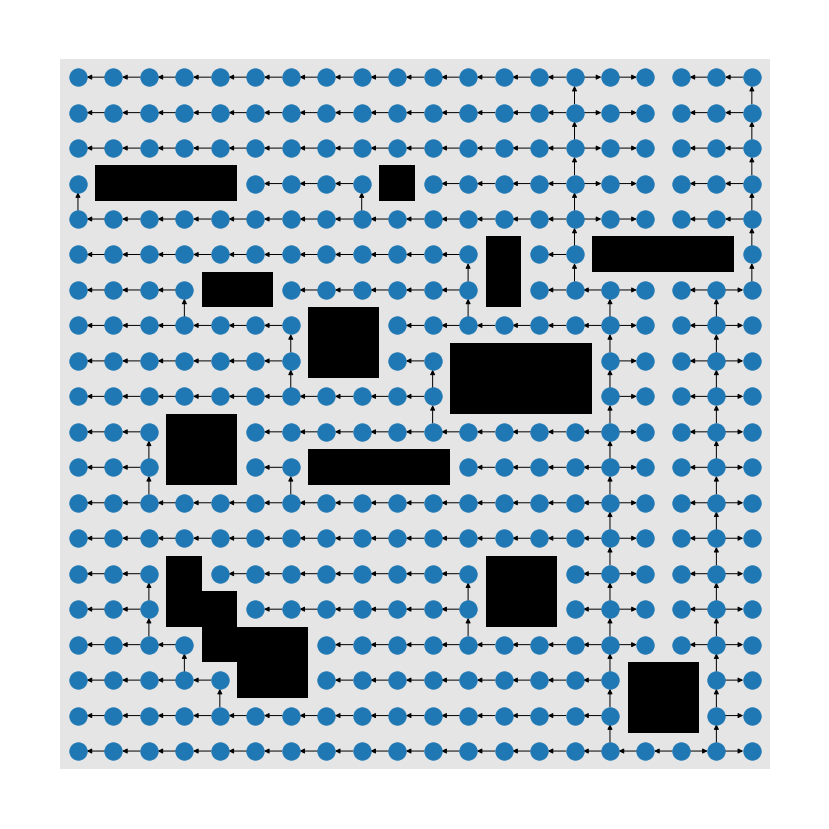

In [42]:
# plot the result of BSF
draw_grid()
nx.draw(bfs_tree, pos = pos)

In [43]:

# Pick the last element and iterate through its predecessors
path = [end_node]   # A path in a graph is a set of connected nodes
current = end_node

# iterate through its predecessors until finding source node
while current != start_node:
    # Predecesors of the current node        
    for pre in bfs_tree.predecessors(current):
        current = pre
    # add the predecessor to the path
    path.append(pre)
        
# The current path starts in the goal node and ends at the start node. So we invert it
path = path[::-1]

# Correct path
print(path)

[(19, 17), (19, 16), (19, 15), (18, 15), (18, 14), (18, 13), (18, 12), (18, 11), (18, 10), (18, 9), (18, 8), (18, 7), (18, 6), (18, 5), (18, 4), (18, 3), (18, 2)]


## Plot the result

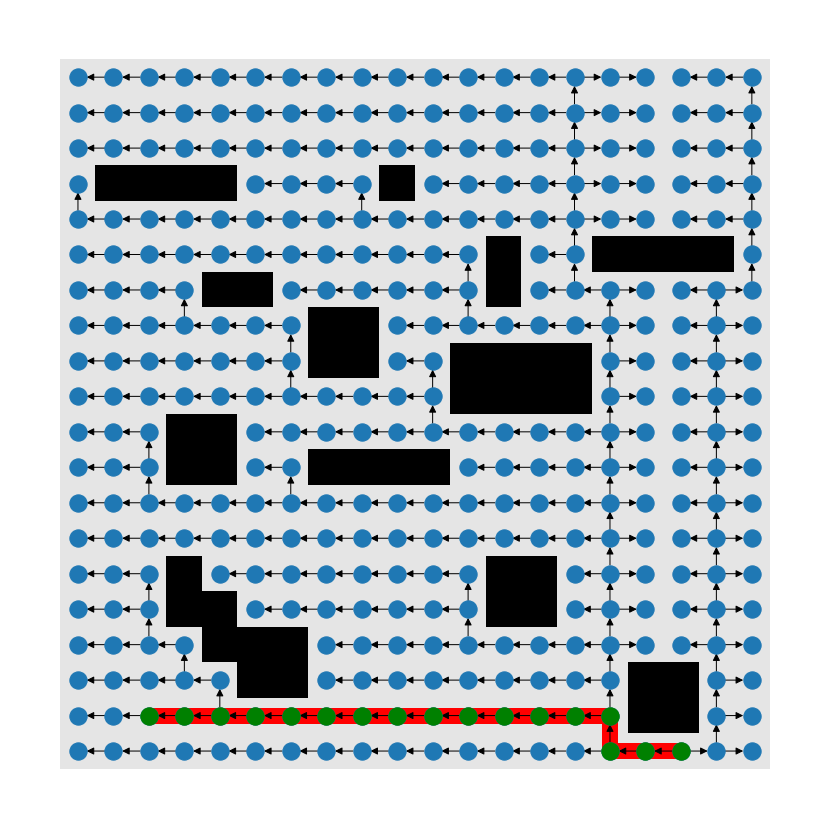

In [44]:
# Edges of the path
E = [(path[i], path[i+1])for i in range(len(path)-1)]

fig, ax = draw_grid()

nx.draw(bfs_tree, pos = pos, arrowsize=15)
nx.draw_networkx_nodes(path, pos, node_color="g")
nx.draw_networkx_edges(G, edgelist=E, pos=pos, edge_color='r',arrowstyle='-|>', arrowsize=10,width=16)

fig.savefig('exp_e42.pdf', bbox_inches="tight")

### Using path as a waypoints

In [45]:


wayptset = asarray(path)
wayptset[:, [1, 0]] = wayptset[:, [0, 1]] 
wayptset += [-10,-10]
wayptset *= [1,-1]

# adding one column with z position in zero

N = len(wayptset)
a = wayptset
b = np.zeros((N,2+1))
b[:,:-1] = a

speed = 30


traj_vars = min_snap_trajectory(0, speed, None, waypts=b)

# Simulation

In [47]:
# Joint name in coppelia
motor_names = ['Omnirob_FLwheel_motor', 'Omnirob_FRwheel_motor', 'Omnirob_RRwheel_motor', 'Omnirob_RLwheel_motor']
r = robot('Omnirob', motor_names)  # Create an instance of our robot

ref_point = robot('desired_point', client_id=r.client_id)

N = len(wayptset)
a = wayptset
b = np.zeros((N,2+1))
b[:,:-1] = a

speed = 30
traj_vars = min_snap_trajectory(0, speed, None, waypts=b)

tf = 30.
tstep = 50e-3

l = 0.347
w = 0.238
ra = 0.040

A = 1/ra*array([[-l-w, 1, -1],
           [l+w, 1, -1],
           [l+w, 1, 1],
           [-l-w, 1, 1]])

# Time interval
time_steps = linspace(0, tf, int(tf/tstep))


for t in time_steps:
    if r.client_id == -1:  # Check connection
        print('Robot is not connected')
        break    
    # Compute the trajectory
    if t <= time_steps[-2]:
        [pos, vel, acc, yaw, yawdot] = min_snap_trajectory(t, speed, traj_vars)
        ref_point.set_position(pos)
    else:
        [pos, vel, acc, yaw, yawdot] = min_snap_trajectory(time_steps[-1], speed, traj_vars)
        ref_point.set_position(pos)
    # Location sesing
    robot_position = r.get_position()
    robot_orientation = r.get_orientation()
    
    # drive the robot using the trajectory tracker
    v = 0.5*(pos - robot_position).dot(Rotz(-pi/2)) #+ vel
    omega = 0.1*(-pi/2 - robot_orientation[2])
#     print(omega,)
    u = A.dot(array([v[1],-omega,v[0]]))
#     print(u)
    
    
    r.send_motor_velocities([u[0], u[1], u[2], u[3]])
#     vy, vx, vz = vel
#     vx = -vx
#     r.send_motor_velocities([-vy - vx, vy - vx, vy + vx, -vy + vx])
    time.sleep(tstep)
#     print(math.atan(1/2))


    
r.send_motor_velocities([0, 0, 0, 0])

r.close_connection()  # End

Robot connected
Robot connected
Connection closed


In [1]:
r.send_motor_velocities([0, 0, 0, 0])

r.close_connection()  # End

NameError: name 'r' is not defined

# A-Star Algoritm

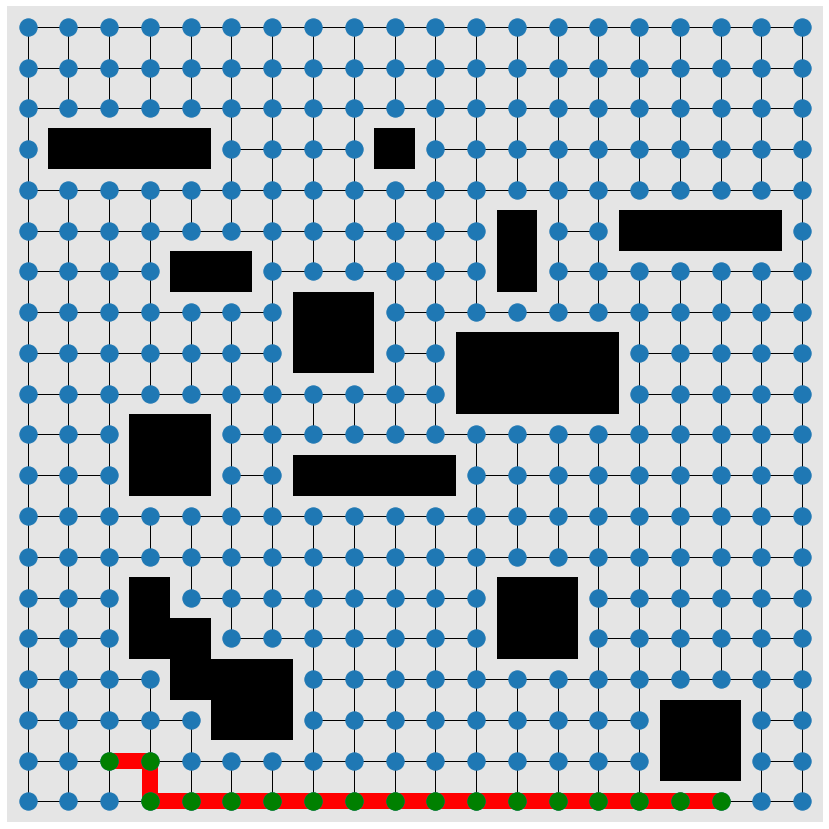

In [51]:

def dist(a, b):
    (x1, y1) = a
    (x2, y2) = b
    return ((x1 - x2) ** 2 + (y1 - y2) ** 2) ** 0.5

start_node =  (19, 17)
end_node = (18,2)


fig, ax = draw_grid()

path1 = nx.astar_path(G, start_node, end_node, heuristic=dist, weight='weight')

pos = {node:(node[1], node[0]) for node in G.nodes()}

E = [(path1[i], path1[i+1])for i in range(len(path1)-1)]

nx.draw(G, pos, with_labels=False, arrows=True)

nx.draw_networkx_edges(G, edgelist=E, pos=pos, edge_color='r',arrowstyle='-|>', arrowsize=10,width=16)
nx.draw_networkx_nodes(path1, pos, node_color="g")

fig.savefig('exp_e43.pdf', bbox_inches="tight")

# Using path as a waypoints

In [52]:

wayptset = asarray(path1)
wayptset[:, [1, 0]] = wayptset[:, [0, 1]] 
wayptset += [-10,-10]
wayptset *= [1,-1]

# adding one column with z position in zero

N = len(wayptset)
a = wayptset
b = np.zeros((N,2+1))
b[:,:-1] = a

speed = 30


traj_vars = min_snap_trajectory(0, speed, None, waypts=b)

## Simulation

In [54]:
# Joint name in coppelia
motor_names = ['Omnirob_FLwheel_motor', 'Omnirob_FRwheel_motor', 'Omnirob_RRwheel_motor', 'Omnirob_RLwheel_motor']
r = robot('Omnirob', motor_names)  # Create an instance of our robot

ref_point = robot('desired_point', client_id=r.client_id)

N = len(wayptset)
a = wayptset
b = np.zeros((N,2+1))
b[:,:-1] = a

speed = 30
traj_vars = min_snap_trajectory(0, speed, None, waypts=b)

tf = 30.
tstep = 50e-3

l = 0.347
w = 0.238
ra = 0.040

A = 1/ra*array([[-l-w, 1, -1],
           [l+w, 1, -1],
           [l+w, 1, 1],
           [-l-w, 1, 1]])

# Time interval
time_steps = linspace(0, tf, int(tf/tstep))


for t in time_steps:
    if r.client_id == -1:  # Check connection
        print('Robot is not connected')
        break    
    # Compute the trajectory
    if t <= time_steps[-2]:
        [pos, vel, acc, yaw, yawdot] = min_snap_trajectory(t, speed, traj_vars)
        ref_point.set_position(pos)
    else:
        [pos, vel, acc, yaw, yawdot] = min_snap_trajectory(time_steps[-1], speed, traj_vars)
        ref_point.set_position(pos)
    # Location sesing
    robot_position = r.get_position()
    robot_orientation = r.get_orientation()
    
    # drive the robot using the trajectory tracker
    v = 0.5*(pos - robot_position).dot(Rotz(-pi/2)) #+ vel
    omega = 0.1*(-pi/2 - robot_orientation[2])
#     print(omega,)
    u = A.dot(array([v[1],-omega,v[0]]))
#     print(u)
    
    
    r.send_motor_velocities([u[0], u[1], u[2], u[3]])
#     vx, vy, vz = vel
#     r.send_motor_velocities([-vy - vx, vy - vx, vy + vx, -vy + vx])
    time.sleep(tstep)
#     print(math.atan(1/2))


    
r.send_motor_velocities([0, 0, 0, 0])

r.close_connection()  # End

Robot connected
Robot connected
Connection closed
